In this notebook I turn the 30mx30m fwi-category fuel data into 300mx300m data

In [1]:
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import datetime
from joblib import Parallel, delayed
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from matplotlib import path 


In [2]:
def build_one_coarse_cell(row_select,col_select,ii,jj):
    #print(ii,jj)
    #tic = datetime.datetime.now()
    win = Window(col_select[jj],row_select[ii],33,33)
    #win = Window(col_select[jj],row_select[ii],12,12)
    #win = Window(col_select,row_select,10,10)
    with rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif') as src: 
        w = src.read(1, window=win)
        w_flat = w.flatten()
        row_win = np.arange(win.row_off,win.row_off+win.height)
        col_win = np.arange(win.col_off,win.col_off+win.width)
        COLS_WIN,ROWS_WIN=np.meshgrid(col_win,row_win)
        
        xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)
    #centers are the middle of the 300mx300m box
    y_ctr =(np.amin(ys_win)+np.amax(ys_win))/2
    x_ctr =(np.amin(xs_win)+np.amax(xs_win))/2
    #print(w_flat)
    #print(loadings.loc[w_flat])
    
    loadings_sub = loadings.loc[w_flat].drop(columns=['Unnamed: 0', 'COUNT','FUELBED_NA'])
    df_cell = pd.DataFrame(loadings_sub.mean(axis=0)).transpose()
    df_cell['y_ctr']=y_ctr
    df_cell['x_ctr'] = x_ctr
    df_cell['row'] = ii
    df_cell['col'] = jj

    #toc = datetime.datetime.now()
    #print(toc-tic)
    return(df_cell.set_index(['row','col']))

In [3]:
#LAT and LON are 2d arrays
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [4]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices
def build_grid_netcdf(LAT_COR, LON_COR, LAT_CTR, LON_CTR, filename):
    #loop over the centers
    nrows_center = LAT_CTR.shape[0]
    ncols_center = LAT_CTR.shape[1]
    print(nrows_center, ncols_center)

    nrows_corner = LAT_COR.shape[0]
    ncols_corner = LAT_COR.shape[1]
    print(nrows_corner,ncols_corner)
    
    rows_ctr = np.arange(nrows_center)
    cols_ctr = np.arange(ncols_center)
    rows_cor = np.arange(nrows_corner)
    cols_cor = np.arange(ncols_corner)

    
    dat_grid = xr.Dataset(
        data_vars = dict(
            LAT_CTR=(['rows_ctr','cols_ctr'],LAT_CTR),
            LON_CTR=(['rows_ctr','cols_ctr'],LON_CTR),
            LAT_COR=(['rows_cor','cols_cor'],LAT_COR),
            LON_COR=(['rows_cor','cols_cor'],LON_COR),
        ),
        
        coords = dict(
            rows_ctr =(['rows_ctr'],rows_ctr),
            cols_ctr =(['cols_ctr'],cols_ctr),
            rows_cor =(['rows_cor'],rows_cor),
            cols_cor =(['cols_cor'],cols_cor),
        
        )
        
    )
    print(dat_grid)
    dat_grid.to_netcdf(filename+'.nc')

In [5]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

# Coarsen the FWI-based loading data

In [ ]:
# All of the code, for use in the python script
loadings = pd.read_csv('FWI_Category_Fuel_Loadings.csv').set_index('VALUE')

#get the dimensions of the whole tif file
src = rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif')

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height,12)
col_coarse = np.arange(0,file_width,12)
print(len(row_coarse), len(col_coarse)) #1.5e8 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)

#select the bounding box
i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
#i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -103, 31, 49]) #smaller, not as far east

#i0, i1, j0, j1 = bbox2ij(lon, lat, [-118.2, -117.4, 33.7, 34.7]) #bobcat
print(i0, i1, j0, j1)
#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1]
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel))

#make the coarse cells
tic = datetime.datetime.now()
print(tic)
coarse_cells = Parallel(n_jobs=24)(delayed(build_one_coarse_cell)
                                 (row_sel,col_sel,xx,yy) 
                                 for xx in range(len(row_sel)) for yy in range(len(col_sel)))
toc =datetime.datetime.now()
print(toc-tic)
coarse_cells_df = pd.concat(coarse_cells)

tic = datetime.datetime.now()
coarse_cells_df=coarse_cells_df.reset_index().set_index(['row','col'])
print(coarse_cells_df.iloc[0:1])
coarse_cells_xr = coarse_cells_df.to_xarray()

toc = datetime.datetime.now()
print(toc-tic)
print(coarse_cells_xr)


source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(coarse_cells_xr['x_ctr'].values, coarse_cells_xr['y_ctr'].values)

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)


#MAKE SURE THE PLOT LOOKS GOOD BEFORE DOING THIS
#put the grid into a netcdf
build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'FUEL_FWI_GRID_360M')

#save the data in another netcdf
coarse_cells_xr=coarse_cells_xr.assign_coords(lat_ctr=(('row', 'col'), lat), 
                                              lon_ctr=(('row', 'col'), lon))


print(coarse_cells_xr['lon_ctr'].values)

print(coarse_cells_xr)
#coarse_cells_xr.to_netcdf('bobcat_fuel_fwi.nc')
coarse_cells_xr.to_netcdf('fuel_fwi_360m.nc')

In [21]:
loadings = pd.read_csv('FWI_Category_Fuel_Loadings.csv').set_index('VALUE')

In [22]:
#get the dimensions of the whole tif file
src = rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif')

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height,33)
col_coarse = np.arange(0,file_width,33)
print(len(row_coarse), len(col_coarse)) #1.5e8 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

1
154208 97283
2948 4673


In [23]:
#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)


0:00:17.019343


In [24]:
#select the bounding box
i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
#i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -103, 31, 49]) #smaller, not as far east

#i0, i1, j0, j1 = bbox2ij(lon, lat, [-118.2, -117.4, 33.7, 34.7]) #bobcat
print(i0, i1, j0, j1)
#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1]
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel))

0 2012 0 2307
2307 2012


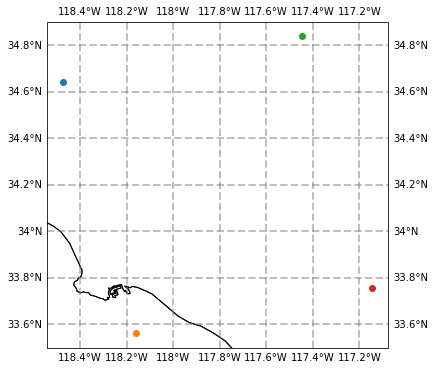

In [11]:
#plot the bounding box, sanity check
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(x=lon[j0,i0],y=lat[j0,i0])
plt.scatter(x=lon[j1,i0],y=lat[j1,i0])
plt.scatter(x=lon[j0,i1],y=lat[j0,i1])
plt.scatter(x=lon[j1,i1],y=lat[j1,i1])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.show()

In [17]:
#make the coarse cells
tic = datetime.datetime.now()
print(tic)
coarse_cells = Parallel(n_jobs=2)(delayed(build_one_coarse_cell)
                                 (row_sel,col_sel,xx,yy) 
                                 for xx in range(len(row_sel)) for yy in range(len(col_sel)))
toc =datetime.datetime.now()
print(toc-tic)
coarse_cells_df = pd.concat(coarse_cells)
print(coarse_cells_df.columns)

#print(build_one_coarse_cell(row_sel,col_sel,0,0))
#print(build_one_coarse_cell(row_sel[100],col_sel[1959]))

2023-02-05 11:58:37.187801
0:01:36.041625
Index(['Extreme_N', 'Extreme_R', 'VeryHigh_N', 'VeryHigh_R', 'High_N',
       'High_R', 'Moderate_N', 'Moderate_R', 'Low_N', 'Low_R', 'y_ctr',
       'x_ctr'],
      dtype='object')


In [18]:
tic = datetime.datetime.now()
#coarse_cells_df=coarse_cells_df.reset_index().set_index(['row','col'])
print(coarse_cells_df.iloc[0:1])
coarse_cells_xr = coarse_cells_df.to_xarray()

toc = datetime.datetime.now()
print(toc-tic)
print(coarse_cells_xr)

         Extreme_N  Extreme_R  VeryHigh_N  VeryHigh_R    High_N    High_R  \
row col                                                                     
0   0     2.671035   0.563892    2.065254    0.398612  1.583719  0.398612   

         Moderate_N  Moderate_R     Low_N     Low_R      y_ctr      x_ctr  
row col                                                                    
0   0      1.057579    0.252064  0.590913  0.182507  1526610.0 -2024340.0  
0:00:00.026322
<xarray.Dataset>
Dimensions:     (col: 97, row: 125)
Coordinates:
  * row         (row) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123 124
  * col         (col) int64 0 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
Data variables:
    Extreme_N   (row, col) float64 2.671 4.457 6.738 ... 0.895 2.491 0.9792
    Extreme_R   (row, col) float64 0.5639 1.042 0.8412 ... 0.02777 0.004591
    VeryHigh_N  (row, col) float64 2.065 3.539 5.307 ... 0.7154 1.991 0.7826
    VeryHigh_R  (row, col) float64 0.3986 0.69 0.7273 .

In [19]:
source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(coarse_cells_xr['x_ctr'].values, coarse_cells_xr['y_ctr'].values)

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)


#MAKE SURE THE PLOT LOOKS GOOD BEFORE DOING THIS
#put the grid into a netcdf
build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'BOBCAT_FUEL_FWI_GRID_990M')

#save the data in another netcdf
coarse_cells_xr=coarse_cells_xr.assign_coords(lat_ctr=(('row', 'col'), lat), 
                                              lon_ctr=(('row', 'col'), lon))


print(coarse_cells_xr['lon_ctr'].values)

print(coarse_cells_xr)
#coarse_cells_xr.to_netcdf('bobcat_fuel_fwi.nc')
coarse_cells_xr.to_netcdf('bobcat_fuel_fwi_990m.nc')

(125, 97)
(124, 96)
125 97
124 96
<xarray.Dataset>
Dimensions:   (cols_cor: 96, cols_ctr: 97, rows_cor: 124, rows_ctr: 125)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 118 119 120 121 122 123 124
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95 96
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 117 118 119 120 121 122 123
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 8 ... 87 88 89 90 91 92 93 94 95
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 34.64 34.64 34.64 ... 33.76 33.76
    LON_CTR   (rows_ctr, cols_ctr) float64 -118.5 -118.5 ... -117.2 -117.2
    LAT_COR   (rows_cor, cols_cor) float64 34.63 34.64 34.64 ... 33.76 33.76
    LON_COR   (rows_cor, cols_cor) float64 -118.5 -118.5 ... -117.2 -117.2
[[-118.467793   -118.45720976 -118.44662596 ... -117.47051613
  -117.45988048 -117.44924429]
 [-118.46524357 -118.45466144 -118.44407874 ... -117.46807184
  -117.45743732 -117.44680225]
 [-118.4626947  -118.45211368 -118.4415

In [ ]:

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
coarse_cells_xr['Low_N'].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon_ctr", y="lat_ctr")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.show()

"""ds.Tair[0].plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="xc", y="yc", add_colorbar=False
)"""

# Coarsen the slope data

In [6]:
def build_one_coarse_slope_cell(row_select,col_select,ii,jj,numcell):
    #print(ii,jj)
    #tic = datetime.datetime.now()
    win = Window(col_select[jj],row_select[ii],numcell,numcell)
    #win = Window(col_select[jj],row_select[ii],12,12)
    #win = Window(col_select,row_select,10,10)
    with rasterio.open('/data2/lthapa/static_maps/LF2016_Slp_200_CONUS/Tif/LC16_Slp_200.tif') as src:        
        w = src.read(1, window=win)
        row_win = np.arange(win.row_off,win.row_off+win.height)
        col_win = np.arange(win.col_off,win.col_off+win.width)
        COLS_WIN,ROWS_WIN=np.meshgrid(col_win,row_win)
        
        xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)
    #centers are the middle of the 300mx300m box
    y_ctr =(np.amin(ys_win)+np.amax(ys_win))/2
    x_ctr =(np.amin(xs_win)+np.amax(xs_win))/2
    #print(w_flat)
    #print(loadings.loc[w_flat])
    

    df_cell = pd.DataFrame()
    w=w.astype(float)
    w[w==-9999] = np.nan
    df_cell.loc[0,'mean_slope'] = np.nanmean(w)
    df_cell.loc[0,'y_ctr']=y_ctr
    df_cell.loc[0,'x_ctr'] = x_ctr
    df_cell.loc[0,'row'] = ii
    df_cell.loc[0,'col'] = jj

    #toc = datetime.datetime.now()
    #print(toc-tic)
    return(df_cell.set_index(['row','col']))

In [7]:
#get some general information about the file (size, CRS, for my reference)
src = rasterio.open('/data2/lthapa/static_maps/LF2016_Slp_200_CONUS/Tif/LC16_Slp_200.tif')
print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height)
print(src.crs)

1
154667 100000
EPSG:5070


## First, grab bobcat at the 30m resolution

In [8]:
#First, grab bobcat at the 30m resolution
p1 = Point(-118.5, 33.5)
p2 = Point(-117.3, 35)

d = {'geometry': [p1, p2]}
gdf = gpd.GeoDataFrame(d, crs=4326)
gdf= gdf.to_crs(5070)
print(gdf)
left = gdf.geometry[0].x
right = gdf.geometry[1].x
bottom = gdf.geometry[0].y
top = gdf.geometry[1].y
print(left,right,bottom,top)

#select the portion of the tif file that corresponds to our western US domain
with rasterio.open('/data2/lthapa/static_maps/LF2016_Slp_200_CONUS/Tif/LC16_Slp_200.tif') as src:
    win = from_bounds(left,bottom,right,top, src.transform)
    print(win)
    w = src.read(1, window=win)
    #start_col = np.floor(win.col_off)
    #end_col = start_col+np.ceil(win.width)
    #start_row=np.floor(win.row_off)
    #end_row = start_row+np.ceil(win.height)
    
    start_col = np.floor(win.col_off)
    end_col = start_col+np.floor(win.width)
    start_row=np.floor(win.row_off)
    end_row = start_row+np.floor(win.height)
    
print(start_row, end_row, start_col,end_col)
row_sel = np.arange(start_row, end_row, 1)
col_sel = np.arange(start_col,end_col,1)

print(len(row_sel), len(col_sel))

#transform the row numbers into x-y coordinates for projection 5070
COLS_WIN,ROWS_WIN=np.meshgrid(col_sel,row_sel)
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

#transform them into lat/lon
source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)

                           geometry
0  POINT (-2056993.279 1403765.768)
1  POINT (-1911913.979 1541963.082)
-2056993.2786384583 -1911913.9789149691 1403765.7677568616 1541963.0823714612
Window(col_off=10181.057378718062, row_off=54515.73058761796, width=4835.976657449632, height=4606.577153819984)
54515.0 59121.0 10181.0 15016.0
4606 4835
(4606, 4835)
(4605, 4834)


In [9]:
print(w.shape)
print(lat.shape)
print(lat_corners.shape)

(4606, 4835)
(4606, 4835)
(4605, 4834)


In [10]:
#build the netcdf for the grid
#build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'BOBCAT_SLOPE_30M')

#build the netcdf for the slope values
ds_slope_save = xr.Dataset(data_vars= {'slope':( ('rows','cols'), w),
                                        'lat':( ('rows','cols'), lat),
                                        'lon':( ('rows','cols'), lon)},
                            coords ={'rows':np.arange(0,w.shape[0],1), 
                                     'cols':np.arange(0,w.shape[1],1)}

                            )
print(ds_slope_save)
ds_slope_save.to_netcdf('bobcat_slope_30m.nc')

<xarray.Dataset>
Dimensions:  (cols: 4835, rows: 4606)
Coordinates:
  * rows     (rows) int64 0 1 2 3 4 5 6 7 ... 4599 4600 4601 4602 4603 4604 4605
  * cols     (cols) int64 0 1 2 3 4 5 6 7 ... 4828 4829 4830 4831 4832 4833 4834
Data variables:
    slope    (rows, cols) int16 25 14 17 22 19 16 27 13 26 ... 0 0 1 1 0 0 0 0 0
    lat      (rows, cols) float64 34.7 34.7 34.7 34.7 ... 33.79 33.79 33.79
    lon      (rows, cols) float64 -118.9 -118.9 -118.9 ... -117.0 -117.0 -117.0


## Now, grab bobcat at coarser resolution

In [8]:
#get the dimensions of the whole tif file
src = rasterio.open('/data2/lthapa/static_maps/LF2016_Slp_200_CONUS/Tif/LC16_Slp_200.tif')

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height) #1.5e10 points total!

row_coarse = np.arange(0, file_height,33)
col_coarse = np.arange(0,file_width,33)
print(len(row_coarse), len(col_coarse)) #1.5e8 points

COLS_WIN,ROWS_WIN=np.meshgrid(col_coarse,row_coarse)

#transform the coarsened grid into lat/lon, so we can select the bounding box
xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)

source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
tic = datetime.datetime.now()
lat, lon = conusAlbers_to_latlon.transform(np.array(xs_win), np.array(ys_win))
toc = datetime.datetime.now()
print(toc-tic)


1
154667 100000
3031 4687
0:00:23.827132


341 437 1666 1792
126 96


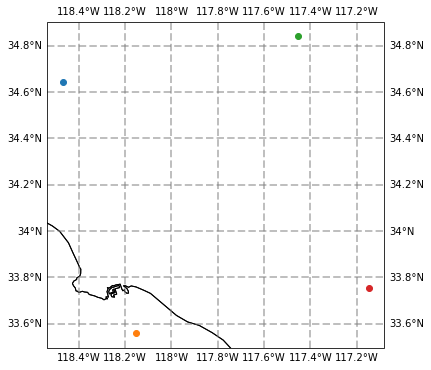

In [13]:
#select the bounding box
#i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -101, 31, 49]) #original one
#i0, i1, j0, j1 = bbox2ij(lon, lat, [-124, -103, 31, 49]) #smaller, not as far east

i0, i1, j0, j1 = bbox2ij(lon, lat, [-118.2, -117.4, 33.7, 34.7]) #bobcat
print(i0, i1, j0, j1)
#print(lon[j0:j1, i0:i1], lat[j0:j1, i0:i1])
row_sel = row_coarse[j0:j1]
col_sel = col_coarse[i0:i1]

print(len(row_sel), len(col_sel))

#plot the bounding box, sanity check
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(x=lon[j0,i0],y=lat[j0,i0])
plt.scatter(x=lon[j1,i0],y=lat[j1,i0])
plt.scatter(x=lon[j0,i1],y=lat[j0,i1])
plt.scatter(x=lon[j1,i1],y=lat[j1,i1])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.show()

In [14]:
#print(build_one_coarse_cell(row_sel,col_sel,0,0))
#print(build_one_coarse_cell(row_sel,col_sel,100,1959))

#make the coarse cells
tic = datetime.datetime.now()
print(tic)
coarse_cells = Parallel(n_jobs=8)(delayed(build_one_coarse_slope_cell)
                                 (row_sel,col_sel,xx,yy,33) 
                                 for xx in range(len(row_sel)) for yy in range(len(col_sel)))
toc =datetime.datetime.now()
print(toc-tic)
coarse_cells_df = pd.concat(coarse_cells)
print(coarse_cells_df.columns)

#print(build_one_coarse_cell(row_sel,col_sel,0,0))
#print(build_one_coarse_cell(row_sel[100],col_sel[1959]))

2023-02-24 13:26:42.144651
0:03:00.770009
Index(['mean_slope', 'y_ctr', 'x_ctr'], dtype='object')


In [15]:
tic = datetime.datetime.now()
#coarse_cells_df=coarse_cells_df.reset_index().set_index(['row','col'])
print(coarse_cells_df.iloc[0:1])
coarse_cells_xr = coarse_cells_df.to_xarray()

toc = datetime.datetime.now()
print(toc-tic)
print(coarse_cells_xr)

         mean_slope      y_ctr      x_ctr
row col                                  
0.0 0.0   25.999082  1527600.0 -2024340.0
0:00:00.117910
<xarray.Dataset>
Dimensions:     (col: 96, row: 126)
Coordinates:
  * row         (row) float64 0.0 1.0 2.0 3.0 4.0 ... 122.0 123.0 124.0 125.0
  * col         (col) float64 0.0 1.0 2.0 3.0 4.0 ... 91.0 92.0 93.0 94.0 95.0
Data variables:
    mean_slope  (row, col) float64 26.0 26.13 22.45 ... 0.3388 0.6795 2.627
    y_ctr       (row, col) float64 1.528e+06 1.528e+06 ... 1.404e+06 1.404e+06
    x_ctr       (row, col) float64 -2.024e+06 -2.023e+06 ... -1.93e+06


In [16]:
source_crs = 'epsg:5070' # Coordinate system of the file, conus Albers
target_crs = 'epsg:4326' # Global lat-lon coordinate system

conusAlbers_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
lat, lon = conusAlbers_to_latlon.transform(coarse_cells_xr['x_ctr'].values, coarse_cells_xr['y_ctr'].values)

print(lat.shape)

lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
print(lat_corners.shape)


#MAKE SURE THE PLOT LOOKS GOOD BEFORE DOING THIS
#put the grid into a netcdf
build_grid_netcdf(lat_corners, lon_corners, lat, lon, 'BOBCAT_SLOPE_GRID_990M')

#save the data in another netcdf
coarse_cells_xr=coarse_cells_xr.assign_coords(lat_ctr=(('row', 'col'), lat), 
                                              lon_ctr=(('row', 'col'), lon))


print(coarse_cells_xr['lon_ctr'].values)

print(coarse_cells_xr)
#coarse_cells_xr.to_netcdf('bobcat_fuel_fwi.nc')
coarse_cells_xr.to_netcdf('bobcat_slope_990m.nc')

(126, 96)
(125, 95)
126 96
125 95
<xarray.Dataset>
Dimensions:   (cols_cor: 95, cols_ctr: 96, rows_cor: 125, rows_ctr: 126)
Coordinates:
  * rows_ctr  (rows_ctr) int64 0 1 2 3 4 5 6 7 ... 119 120 121 122 123 124 125
  * cols_ctr  (cols_ctr) int64 0 1 2 3 4 5 6 7 8 ... 87 88 89 90 91 92 93 94 95
  * rows_cor  (rows_cor) int64 0 1 2 3 4 5 6 7 ... 118 119 120 121 122 123 124
  * cols_cor  (cols_cor) int64 0 1 2 3 4 5 6 7 8 ... 86 87 88 89 90 91 92 93 94
Data variables:
    LAT_CTR   (rows_ctr, cols_ctr) float64 34.65 34.65 34.65 ... 33.76 33.76
    LON_CTR   (rows_ctr, cols_ctr) float64 -118.5 -118.5 ... -117.2 -117.2
    LAT_COR   (rows_cor, cols_cor) float64 34.64 34.64 34.65 ... 33.76 33.76
    LON_COR   (rows_cor, cols_cor) float64 -118.5 -118.5 ... -117.2 -117.2
[[-118.47034301 -118.45975866 -118.44917374 ... -117.4835972
  -117.47296097 -117.46232419]
 [-118.467793   -118.45720976 -118.44662596 ... -117.48115123
  -117.47051613 -117.45988048]
 [-118.46524357 -118.45466144 -118.44407

# Old/Testing Code

In [14]:
a = np.ones((3,4))
a[0,2] = 3
a[0,1] = 4
a[a==0] = np.nan

print(a)
print(np.nanmean(a))

[[1. 4. 3. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
1.4166666666666667


In [31]:
listi = []
tic = datetime.datetime.now()

results = Parallel(n_jobs=2)(delayed(listi.append[ii])
                                 (ii) for ii in range(10))

print(results)
toc = datetime.datetime.now()
print(toc-tic)
#print(listi)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

a = np.zeros((1000000))
#print(a)

tic = datetime.datetime.now()
pool = mp.Pool(2)
results = pool.starmap(fill_a, [(a,xx) for xx in range(1000000)]) 
pool.close() 
toc = datetime.datetime.now()
print(toc-tic)
print(type(results))
print(np.array(results).shape)
    
"""
a_filled = Parallel(n_jobs=2)(delayed(fill_a)
                                 (a,xx) 
                                 for xx in range(10))
print(a_filled)"""

In [8]:
def fill_a(a_to_fill,ii):
    a_to_fill[ii] = ii
    return a_to_fill

In [ ]:
#these are the rows and columns we will use to select the grid boxes. 
#They physically correspond to corners of our resulting grid boxes
row_select = np.arange(start_row, end_row, 10)
col_select = np.arange(start_col,end_col,10)


#preallocate the variables
lat_ctrs = np.zeros((len(row_select),len(col_select)))
lon_ctrs = np.zeros((len(row_select),len(col_select)))
lat_ctrs = np.zeros((len(row_select),len(col_select)))

loading_new_extreme = np.zeros((len(row_select),len(col_select)))
loading_residual_extreme = np.zeros((len(row_select),len(col_select)))
loading_new_veryhigh = np.zeros((len(row_select),len(col_select)))
loading_residual_veryhigh = np.zeros((len(row_select),len(col_select)))
loading_new_high = np.zeros((len(row_select),len(col_select)))
loading_residual_high = np.zeros((len(row_select),len(col_select)))
loading_new_moderate = np.zeros((len(row_select),len(col_select)))
loading_residual_moderate = np.zeros((len(row_select),len(col_select)))
loading_new_low = np.zeros((len(row_select),len(col_select)))
loading_residual_low = np.zeros((len(row_select),len(col_select)))


for ii in range(len(row_select)):
    print(ii)
    for jj in range(len(col_select)):
        
        win = Window(col_select[jj],row_select[ii],10,10)
        row_win = np.arange(win.row_off,win.row_off+win.height)
        col_win = np.arange(win.col_off,win.col_off+win.width)
        COLS_WIN,ROWS_WIN=np.meshgrid(col_win,row_win)
        xs_win, ys_win = rasterio.transform.xy(src.transform, ROWS_WIN, COLS_WIN)
        xs_win_1d = np.array(xs_win)[0,:]
        ys_win_1d = np.array(ys_win)[:,0]
        
        #centers are the middle of the 300mx300m box
        lat_ctrs[ii,jj] =(np.min(xs_win_1d)+np.max(xs_win_1d))/2
        lon_ctrs[ii,jj] =(np.min(ys_win_1d)+np.max(ys_win_1d))/2

        w = src.read(1, window=win)
        w_flat = w.flatten()
        
        if len(w_flat)==0:
            loading_new_extreme[ii,jj] = np.nan
            loading_new_veryhigh[ii,jj] = np.nan
            loading_new_high[ii,jj] = np.nan
            loading_new_moderate[ii,jj] = np.nan
            loading_new_low[ii,jj] =np.nan

        else:
            loading_new_extreme[ii,jj] = np.nanmean(loadings.loc[w_flat,'Extreme_N'].values)
            loading_residual_extreme[ii,jj] = np.nanmean(loadings.loc[w_flat,'Extreme_R'].values)
            loading_new_veryhigh[ii,jj] = np.nanmean(loadings.loc[w_flat,'VeryHigh_N'].values)
            loading_residual_veryhigh[ii,jj] = np.nanmean(loadings.loc[w_flat,'VeryHigh_R'].values)
            loading_new_high[ii,jj] = np.nanmean(loadings.loc[w_flat,'High_N'].values)
            loading_residual_high[ii,jj] = np.nanmean(loadings.loc[w_flat,'High_R'].values)
            loading_new_moderate[ii,jj] = np.nanmean(loadings.loc[w_flat,'Moderate_N'].values)
            loading_residual_moderate[ii,jj] = np.nanmean(loadings.loc[w_flat,'Moderate_R'].values)
            loading_new_low[ii,jj] =np.nanmean(loadings.loc[w_flat,'Low_N'].values)
            loading_residual_low[ii,jj] =np.nanmean(loadings.loc[w_flat,'Low_R'].values)       

In [ ]:
row_sel = np.arange(start_row, end_row, 10)
col_sel = np.arange(start_col,end_col,10)

count=0
for ii in range(len(row_sel)):
    for jj in range(len(col_sel)):
        print(ii,jj)
        win = Window(col_sel[jj],row_sel[ii],10,10)
        with rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif') as src: 
            w = src.read(1, window=win)
            w_flat = w.flatten()
        
        if len(w_flat)==0:
            count = count+1
            print(count)

In [ ]:
fire_incidents = ['BOBCAT']

path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for jj in range(len(fire_incidents)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    fire_daily = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    print(fire_daily.crs)
    fire_daily=fire_daily.drop(columns=['Current Overpass'])
    fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
    fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
    fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
    fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'Local Day': str(start_time)+ 'Z Start Day'})
    
    fire_daily = fire_daily.iloc[np.array(fire_daily['UTC Day'].values,dtype='datetime64')<=np.datetime64('2020-10-31'),:]

In [ ]:
src = rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif')

print(src.count) #number of bands/data layers
file_width = src.width
file_height = src.height
print(file_width, file_height)

win1=Window(0, 0, 10, 10)
print(win1)
w1 = src.read(1, window=win1)
rows = np.arange(win1.row_off,win1.row_off+win1.height-1)
cols = np.arange(win1.col_off,win1.col_off+win1.width-1)
COLS,ROWS=np.meshgrid(cols,rows)

xs, ys = rasterio.transform.xy(src.transform, ROWS, COLS)
print(np.array(xs))

show(w)

In [ ]:
    """if len(w_flat)==0:
        df_cell = pd.DataFrame({'Extreme_N':np.nan,
                           'Extreme_R':np.nan,
                           'VeryHigh_N':np.nan,
                           'VeryHigh_R':np.nan,
                           'High_N':np.nan,
                           'High_R':np.nan,
                           'Moderate_N':np.nan,
                           'Moderate_R':np.nan,
                           'Low_N':np.nan,
                           'Low_R':np.nan,
                           'lat_ctr':lat_ctr,'lon_ctr':lon_ctr,}, index=[0])

    else:
        loadings_sub = loadings.loc[w_flat].drop(columns=['Unnamed: 0', 'COUNT','FUELBED_NA'])
        df_cell = pd.DataFrame(loadings_sub.mean(axis=0)).transpose()
        df_cell['lat_ctr']=lat_ctr
        df_cell['lon_ctr'] = lon_ctr
        
        """"""df_cell = pd.DataFrame({'lat_ctr':lat_ctr,'lon_ctr':lon_ctr,
                           'loading_new_extreme':np.nanmean(loadings.loc[w_flat,'Extreme_N'].values),
                           'loading_residual_extreme':np.nanmean(loadings.loc[w_flat,'Extreme_R'].values),
                           'loading_new_veryhigh':np.nanmean(loadings.loc[w_flat,'VeryHigh_N'].values),
                           'loading_residual_veryhigh':np.nanmean(loadings.loc[w_flat,'VeryHigh_R'].values),
                           'loading_new_high':np.nanmean(loadings.loc[w_flat,'High_N'].values),
                           'loading_residual_high':np.nanmean(loadings.loc[w_flat,'High_R'].values),
                           'loading_new_moderate':np.nanmean(loadings.loc[w_flat,'Moderate_N'].values),
                           'loading_residual_moderate':np.nanmean(loadings.loc[w_flat,'Moderate_R'].values),
                           'loading_new_low':np.nanmean(loadings.loc[w_flat,'Low_N'].values),
                           'loading_residual_low':np.nanmean(loadings.loc[w_flat,'Low_R'].values),}, index=[0])""""""  
    
    return(df_cell)"""

In [ ]:
#p1 = Point(-125,31) #bottom left of domain
#p2 = Point(-101,49) #top right of domain

#p1 = Point(-125,25) #bottom left of extended domain
#p2 = Point(-90,49) #top right of extended domain


#bobcat, final extent
#p1 = Point(-118.5, 33.5)
#p2 = Point(-117.3, 35)

d = {'geometry': [p1, p2]}
gdf = gpd.GeoDataFrame(d, crs=4326)
gdf= gdf.to_crs(5070)
print(gdf)
left = gdf.geometry[0].x
right = gdf.geometry[1].x
bottom = gdf.geometry[0].y
top = gdf.geometry[1].y
print(left,right,bottom,top)

#select the portion of the tif file that corresponds to our western US domain
with rasterio.open('../FCCS_Fuel_Fire_Danger_Metric.tif') as src:
    win = from_bounds(left,bottom,right,top, src.transform)
    print(win)
    start_col = np.floor(win.col_off)
    end_col = start_col+np.ceil(win.width)
    start_row=np.floor(win.row_off)
    end_row = start_row+np.ceil(win.height)
    
print(start_row, end_row, start_col,end_col)

#these are the rows and columns we will use to select the grid boxes. 
#They physically correspond to corners of our resulting grid boxes
row_sel = np.arange(start_row, end_row, 1000)
col_sel = np.arange(start_col,end_col,1000)
print(end_row-start_row,end_col-start_col)
print(len(row_sel), len(col_sel))

